#### Summary:
In this notebook I'll implement downstream analyses on the results from the final ATAC trait associations.

In [1]:
suppressMessages(library(dplyr)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressMessages(library(readr))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

suppressMessages(library(parallel))
suppressMessages(library(enrichR))
suppressMessages(library(rWikiPathways))
suppressMessages(library(fgsea))

# Basic Inputs

In [2]:
alberta_samples <- c('R207','R217','R218','R221','R223',
                      'R226','R228','R234','R237','R238',
                      'R246', 'R247', 'R275', 'R284', 
                      'R290', 'R292', 'R316', 'R317', 'R319',
                      'R325','R326','R327','R332',
                      'R353','R354','R362','R363','R364')

hpap_samples_atac <- c('HPAP-035','HPAP-036','HPAP-039','HPAP-040','HPAP-044',
                       'HPAP-045','HPAP-047','HPAP-049','HPAP-050','HPAP-052',
                       'HPAP-053','HPAP-054','HPAP-056','HPAP-059','HPAP-063',
                       'HPAP-067','HPAP-069','HPAP-072','HPAP-075','HPAP-077',
                       'HPAP-080','HPAP-092','HPAP-099','HPAP-101','HPAP-103',
                       'HPAP-104','HPAP-105')
length(hpap_samples_atac)

[1] 27

In [15]:
outdir <- '/overall/dir/to/save/phenotype/association/outputs/to'
deseq_outdir <- file.path(outdir,'ATAC','DESeq')
bg_dir <- '/path/to/all/peaks/accessible/per/celltype.bed'
links_dir <- '/path/to/3methods/combined/links/files'

In [4]:
#only run ATAC on larger cell types bc of data sparsity
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal')

In [ ]:
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B',
            '#F5DE6C', '#752BBA', '#F598C9','#FDBB84')
names(colors) <- joint_celltypes

In [6]:
traits <- c('scaled_age','scaled_BMI','scaled_HbA1c','sex')

In [7]:
link_methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic','hm','abc','cic')
no_cic_link_methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic','hm','abc')
overlap_link_methods <- c('hm_abc_cic','hm_abc','hm_cic','abc_cic')

# 1. Pull out bed files of significant peaks

In [8]:
### Function to make bed files of sig peaks
### PVALUE CUTOFF VERSION -- easy enough to change to using a qvalue cutoff
get_sig_peaks <- function(celltype, trait, dir, deseq_dir, outdir, min_peaks=5, p_cutoff=0.01){
    #create a bed file of sig results for input dir
    fp <- file.path(deseq_outdir,trait,sprintf('ATAC_deseq_v4.%s.%s.tsv',trait, celltype))
    df <- read.table(fp, sep='\t', header=1)
    if (dir=='up') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange > 0)
    if (dir=='down') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange < 0)    
    
    sig_peaks <- row.names(df_sig_dir)
    sig_df <- as.data.frame(str_split_fixed(sig_peaks,'-',3))
    sig_df$V4 <- sig_peaks
    
    #if enough sig peaks, proceed
    if(dim(sig_df)[1] >= min_peaks){
        out_fp <- file.path(outdir,'ATAC','sig_assoc_peaks',trait,sprintf('%s_%s_sig_peaks_%s.bed', celltype, trait, dir))
        write.table(sig_df, out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    } else {
        print(sprintf('Not enough sig peaks for %s and %s %s associations (n=%s)',celltype, trait, dir, dim(sig_df)[1]))
    }
}

In [13]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
script_fp <- file.path(great_dir,'240625_GREAT_web_submissions.sh')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
             get_sig_peaks(celltype, trait, dir, deseq_outdir, outdir)           
        }
    }
}

## Prepare files for GREAT and submit jobs via HTTP web submission

In [5]:
great_dir <- file.path(outdir,'ATAC/GREAT_p0.01')
aws_dir <- 'hmummey/GREAT_websubmit/240625_p01'

In [7]:
bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/240304_union_peaks/celltype_union_peaks'

# First make named cell type union peak reference files and upload to AWS
for(celltype in joint_celltypes){
    #read in celltype peaks file and remake name col to be peak coords
    ct_fp1 <- file.path(bg_dir,sprintf('%s.union_peaks.bed',celltype))
    ct_peaks <- read.table(ct_fp1, sep='\t')
    ct_peaks$V4 <- paste(ct_peaks$V1, ct_peaks$V2, ct_peaks$V3, sep='-')
    
    #write out to new file with only autosomal peaks
    ct_peaks_auto <- subset(ct_peaks, !grepl('chrX|chrY',V1))
    fp_name <- sprintf('%s_union_peaks.bed',celltype)
    ct_fp2 <- file.path(great_dir,'ct_peaks',fp_name)
    write.table(ct_peaks_auto, ct_fp2, sep='\t', row.names=F, col.names=F, quote=F)

    #upload file to AWS directory I prepared
    system(sprintf('aws s3 cp %s s3://gaulton-lab-ucsc/%s/%s', ct_fp2, aws_dir, fp_name))   
}

In [8]:
### Function to prep associations file for GREAT, upload it to AWS and submit the job to their web service
### PVALUE CUTOFF VERSION
run_GREAT2 <- function(celltype, trait, dir, deseq_dir, great_dir, aws_dir, script_fp, min_peaks=5, p_cutoff=0.01){
    #create a bed file of sig results for input dir
    fp <- file.path(deseq_outdir,trait,sprintf('ATAC_deseq_v4.%s.%s.tsv',trait, celltype))
    df <- read.table(fp, sep='\t', header=1)
    if (dir=='up') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange > 0)
    if (dir=='down') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange < 0)    
    
    sig_peaks <- row.names(df_sig_dir)
    sig_df <- as.data.frame(str_split_fixed(sig_peaks,'-',3))
    sig_df$V4 <- sig_peaks
    
    #if enough sig peaks, proceed
    if(dim(sig_df)[1] >= min_peaks){
        out_fp <- file.path(great_dir,'sig_assoc_peaks',trait,sprintf('%s_%s_sig_peaks_%s.bed', celltype, trait, dir))
        write.table(sig_df, out_fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)

        #upload assoc file to AWS
        sig_prefix <- sprintf('%s_%s_sig_peaks_%s.bed',celltype, trait, dir)
        system(sprintf('aws s3 cp %s s3://gaulton-lab-ucsc/%s/%s', out_fp, aws_dir, sig_prefix))   

        #build and run the wget command to send these to the GREAT webserver
        results_fp <- file.path(great_dir,'results',trait,sprintf('%s_%s_%s_GREAT_webserver_results.tsv',celltype,trait,dir))
        request_name <- paste(celltype,trait,dir,sep='_')
        request_url <- sprintf('https://s3-us-west-2.amazonaws.com/gaulton-lab-ucsc/%s/%s',aws_dir, sig_prefix)
        bg_url <- sprintf('https://s3-us-west-2.amazonaws.com/gaulton-lab-ucsc/%s/%s_union_peaks.bed',aws_dir, celltype)
        request_url_http <- gsub(':','%3A', gsub('/','%2F',request_url))
        bg_url_http <- gsub(':','%3A', gsub('/','%2F',bg_url))

        #cmd inputs: fp to save results to, name for request (doesn't matter), input peaks AWS url HTTP format, background peaks AWS url HTTP format
        cmd <- sprintf('wget -O %s "http://bejerano.stanford.edu/great/public/cgi-bin/greatStart.php?outputType=batch&requestSpecies=hg38&requestName=%s&requestSender=Client+A&requestURL=%s&bgURL=%s"',results_fp,request_name,request_url_http,bg_url_http)
        #running this from jupyter is getting a bit weird (maybe adds weird \ to the wget statement?)
        #gonna try writing the commands to a file instead and run from the terminal -- works :)
        write(cmd, script_fp, append=TRUE)
        write('sleep 1m', script_fp, append=TRUE) #only supposed to submit one job every minute
    } else {
        print(sprintf('Not enough sig peaks for %s and %s %s associations (n=%s)',celltype, trait, dir, dim(sig_df)[1]))
    }
}

In [13]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
script_fp <- file.path(great_dir,'240625_GREAT_web_submissions.sh')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
             run_GREAT2(celltype, trait, dir, deseq_outdir, great_dir, aws_dir, script_fp)           
        }
    }
}

Before writing to the script, touch the file and add the appropriate shebang to the top (I use `#!/bin/bash`), then after writing all the commands to it run the script from a screen with `bash $script_fp`

## Plot summaries of pathway enrichment results
Ontology options:
- All Ontologies (no subsetting)
- Ensembl Genes
- GO Biological Process
- GO Cellular Component 
- GO Molecular Function
- Human Phenotype
- Mouse Phenotype 
- Mouse Phenotype Single KO 

In [14]:
### Function to plot summaries of GREAT enrichment results (ALL or specific ontology sets)
plot_great_summary <- function(celltypes, traits, results_dir, ontology, colors, padj_cutoff=0.1){
    #summarize enrichments (read in both up and down results)
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(results_dir, trait, sprintf('%s_%s_up_GREAT_webserver_results.tsv', celltype, trait))
            #check if association was run before continuing!
            if(file.exists(fp)){
                df_pre <- suppressMessages(head(vroom::vroom(fp, skip=3),-10))
                colnames(df_pre)[1] <- 'Ontology'
                if(ontology != 'All Ontologies'){
                    df <- subset(df_pre,Ontology==ontology)
                } else {
                    df <- df_pre
                }
                num_sig <- c(num_sig, dim(df[df$HyperFdrQ < padj_cutoff,])[1])
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    
    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(results_dir, trait, sprintf('%s_%s_down_GREAT_webserver_results.tsv', celltype, trait))
            #check if association was run before continuing!
            if(file.exists(fp)){
                df_pre <- suppressMessages(head(vroom::vroom(fp, skip=3),-10))
                colnames(df_pre)[1] <- 'Ontology'
                if(ontology != 'All Ontologies'){
                    df <- subset(df_pre,Ontology==ontology)
                } else {
                    df <- df_pre
                }
                num_sig <- c(num_sig, dim(df[df$HyperFdrQ < padj_cutoff,])[1])
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    #prep data for plotting
    rownames(summary_df_up) <- celltypes
    colnames(summary_df_up) <- traits
    summary_df_up$celltype <- celltypes
    rownames(summary_df_down) <- celltypes
    colnames(summary_df_down) <- traits
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'),melt(summary_df_down, id.vars='celltype'))
    
    #make plot
    options(repr.plot.width=16, repr.plot.height=6)
    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Cell type", y='Num sig pathways', color="Cell Type", title=ontology) + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
                axis.text.y=element_text(size=20, vjust=0.5),
                axis.title.x = element_text(size=25, vjust=-0.35),
                axis.title.y = element_text(size=25, vjust=0.5),
                legend.title = element_blank(),
                legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

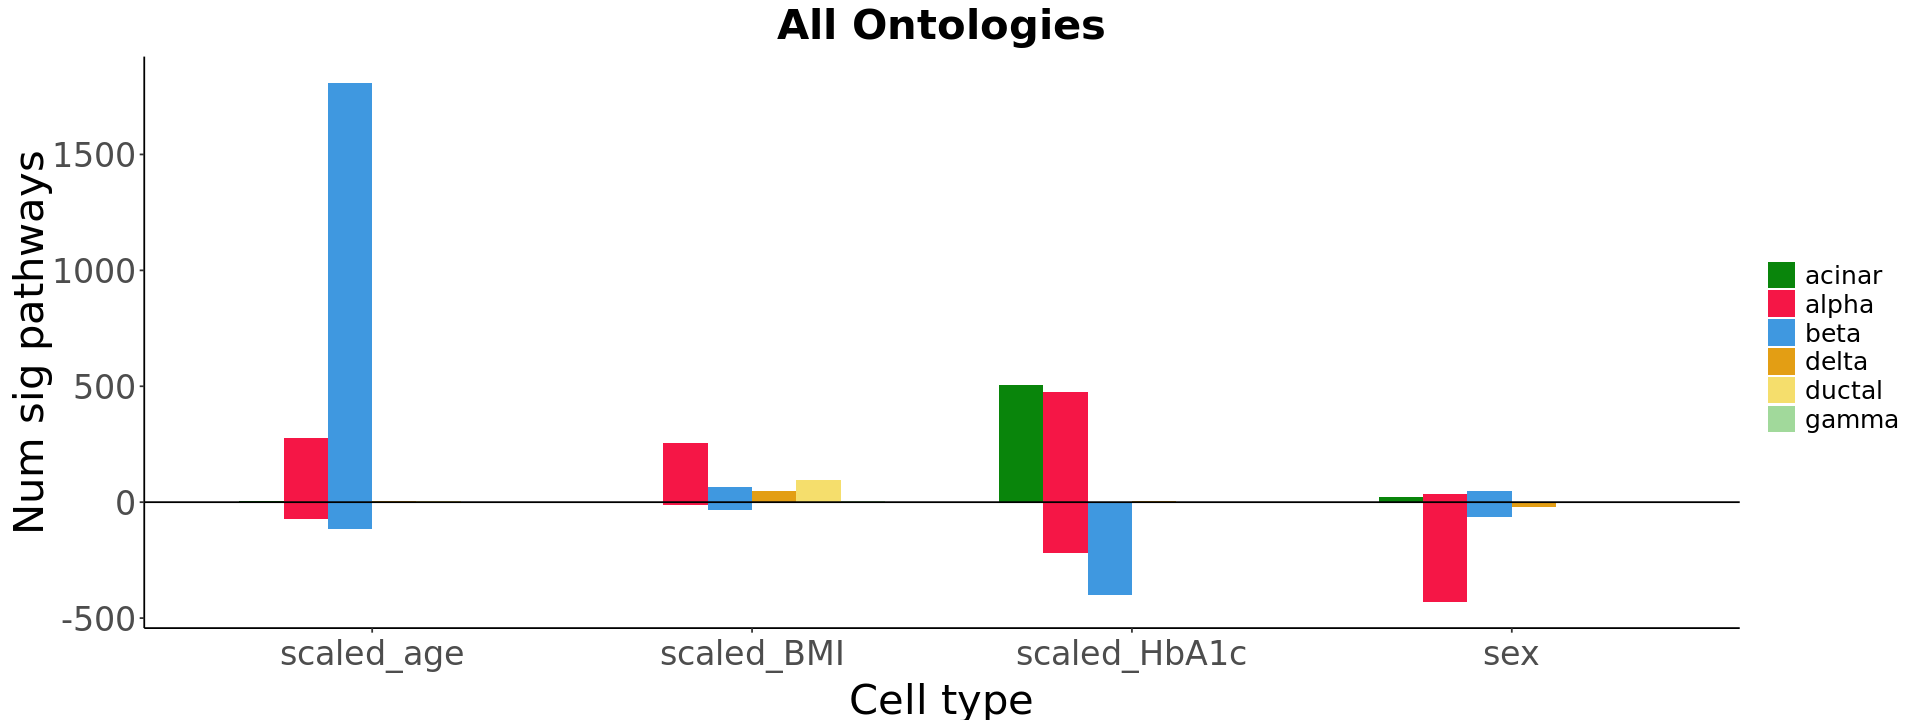

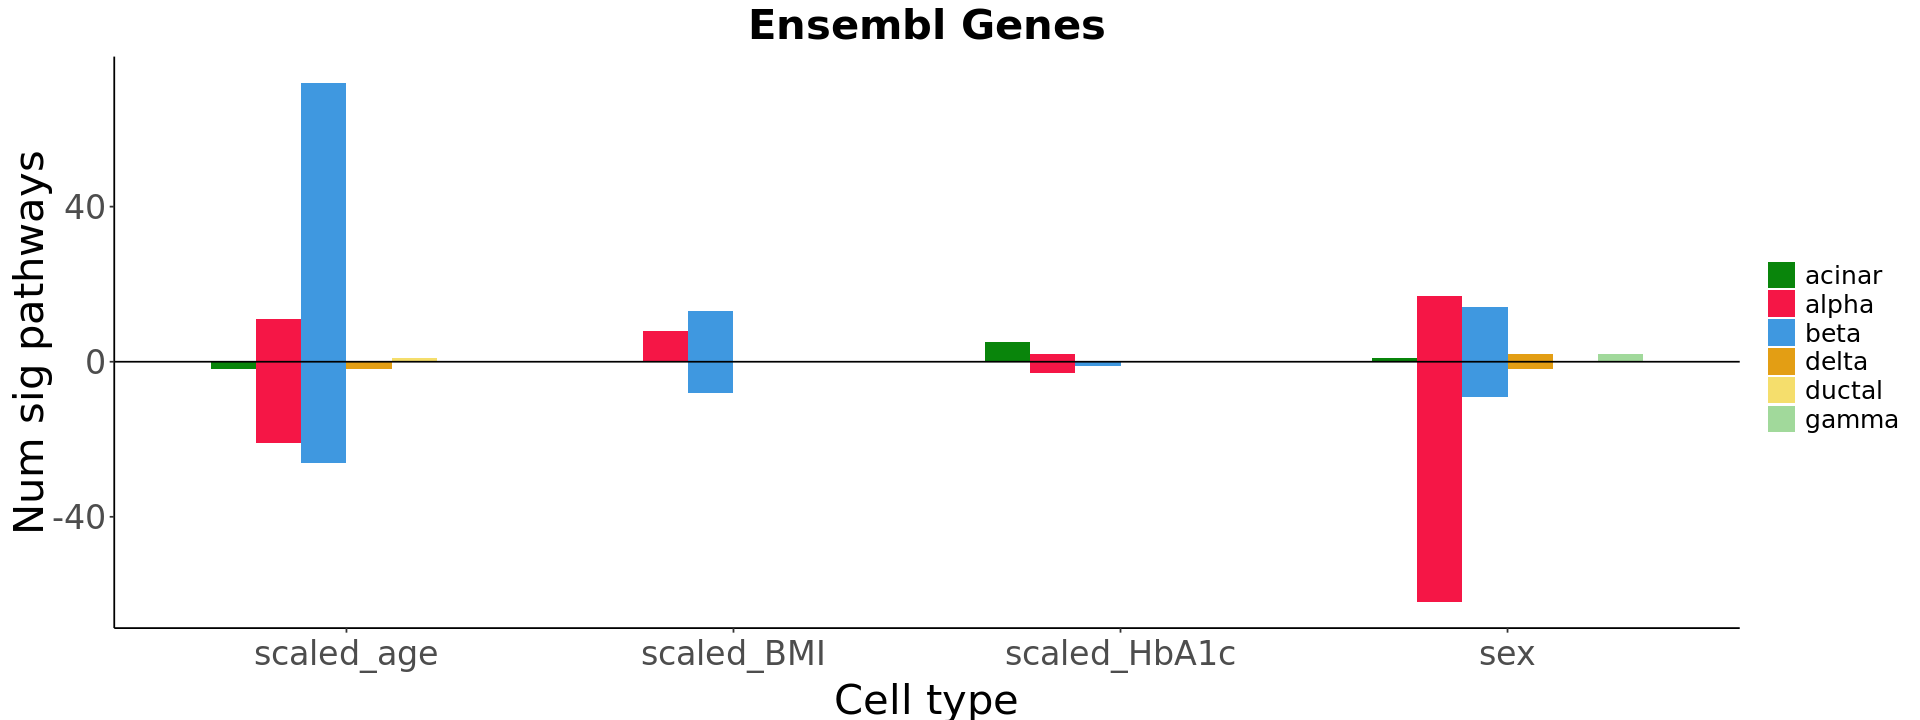

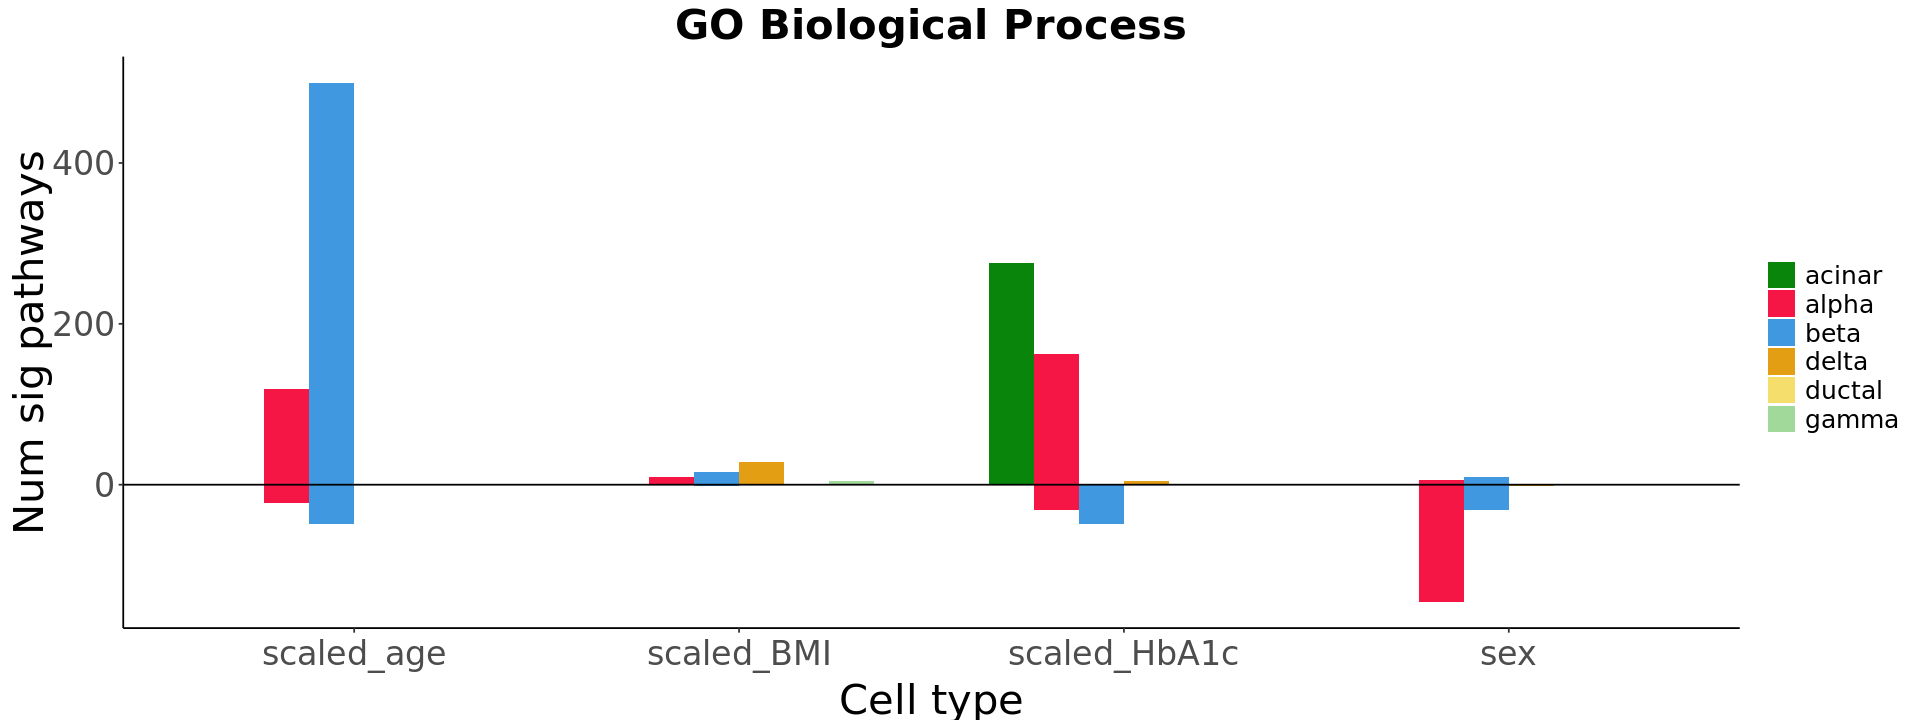

In [18]:
results_dir <- file.path(great_dir,'results')
theme_set(theme_classic())

suppressWarnings(plot_great_summary(joint_celltypes,traits,results_dir,'All Ontologies',colors))
suppressWarnings(plot_great_summary(joint_celltypes,traits,results_dir,'Ensembl Genes',colors))
suppressWarnings(plot_great_summary(joint_celltypes,traits,results_dir,'GO Biological Process',colors))

## Plot top Ontology results
Ontology options:
- All Ontologies (no subsetting)
- Ensembl Genes
- GO Biological Process
- GO Cellular Component 
- GO Molecular Function
- Human Phenotype
- Mouse Phenotype 
- Mouse Phenotype Single KO 

In [19]:
#adapting previous plotting function to just make one plot at a time so I can make a composite plot more easily
#GREAT only tests for enrichcment, so no need to test directions

great_plt <- function(data, trait, dir, color, make_plot=TRUE, numpathways=10, labelthresh=1){
    plt_title <- sprintf('%s GREAT %s pathways (-log10p)', trait, dir)

    #if the GREAT analysis was run make_plot is initially TRUE
    if(make_plot==TRUE){
        #BUT also need to check if anything passed significance
        if(dim(data)[1] > 0){
            #prepare df for plotting
            data$LOG10P <- -log10(data$HyperP)
            data <- data[order(data$HyperP),]
            plt_data <- data[c(1:numpathways),]            
        } else {
            make_plot <- FALSE
        }
    }
        
    #make plot if there is data
    if (make_plot == TRUE){        
        #factor pathways (idk why)
        plt_data$Desc <- factor(plt_data$Desc, levels= plt_data$Desc)
        plt_data$Desc <- fct_rev(plt_data$Desc)

        #make plot 
        plt <- ggplot(plt_data) +
                      geom_col(aes(LOG10P, Desc), fill= color, width = 0.9) + theme_classic() + 
                      scale_x_continuous(limits = c(0, (ceiling(max(plt_data$LOG10P, na.rm = TRUE)) + 0.5)),
                        breaks = seq(0, ceiling(max(plt_data$LOG10P, na.rm = TRUE)), by = 3), 
                        expand = c(0, 0), # The horizontal axis does not extend to either side
                        position = 'top') + # Labels are located on the top
                      scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
                      theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16)) + 
                      geom_shadowtext(
                        data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = Desc, label = Desc),
                        hjust = 0,
                        nudge_x = 0.3,
                        colour = 'white',
                        bg.colour = color,
                        bg.r = 0.2,
                        size = 10) + 
                      geom_text(data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = Desc, label = Desc),
                        hjust = 0,nudge_x = 0.3,colour = 'white',size = 10) +
                      labs(title = '', subtitle = plt_title) +
                      theme(plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))  
        
    #if no data passes sig threshold return blank plot
    } else {
        plt <- ggplot(data) + 
                    geom_blank() + 
                    labs(title = '', subtitle = plt_title) +
                    theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16),
                        plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    }
    return(plt)
}

In [20]:
### Function to use my adapted version of Ruth's pathway enrichment plots on the GREAT results
make_ct_great_plots <- function(celltype, traits, ontology, colors, padj_cutoff=0.1){
    plot_list <- list()
    
    #set up up/down colors
    ct_colors <- list()
    ct_colors[['up']] <- colors[[celltype]]
    ct_colors[['down']] <- colorRampPalette(colors = c('black',colors[[celltype]]))(4)[3]
    
    for (trait in traits){
        for (dir in c('up','down')){
            fp <- file.path(results_dir, trait, sprintf('%s_%s_%s_GREAT_webserver_results.tsv', celltype, trait, dir))
            #check if association was run before continuing!
            if(file.exists(fp)){
                df_pre <- suppressMessages(head(vroom::vroom(fp, skip=3),-10))
                colnames(df_pre)[1] <- 'Ontology'
                df <- subset(df_pre,Ontology==ontology)
                df_sig <- subset(df, HyperFdrQ < padj_cutoff)    
                make_plot <- TRUE
            } else {
                make_plot <- FALSE
                df_sig <- df
            }    
            # Call newly adapted version Ruth's function to make up and down plots separately
            plt <- great_plt(df_sig, trait, dir, ct_colors[[dir]], make_plot)
            plot_list[[paste(trait,dir,sep='_')]] <- plt
        }
    }
    #make composite plot
    options(repr.plot.width = 32, repr.plot.height=10)
    fig <- ggarrange(plotlist = plot_list, nrow=2, ncol=4)
    fig <- annotate_figure(fig, top=text_grob(sprintf("GREAT %s pathways for %s cells (DESeq phenotype associations)", ontology, celltype),
                           color = 'black', face='bold', size=25))
    print(fig)
    
}


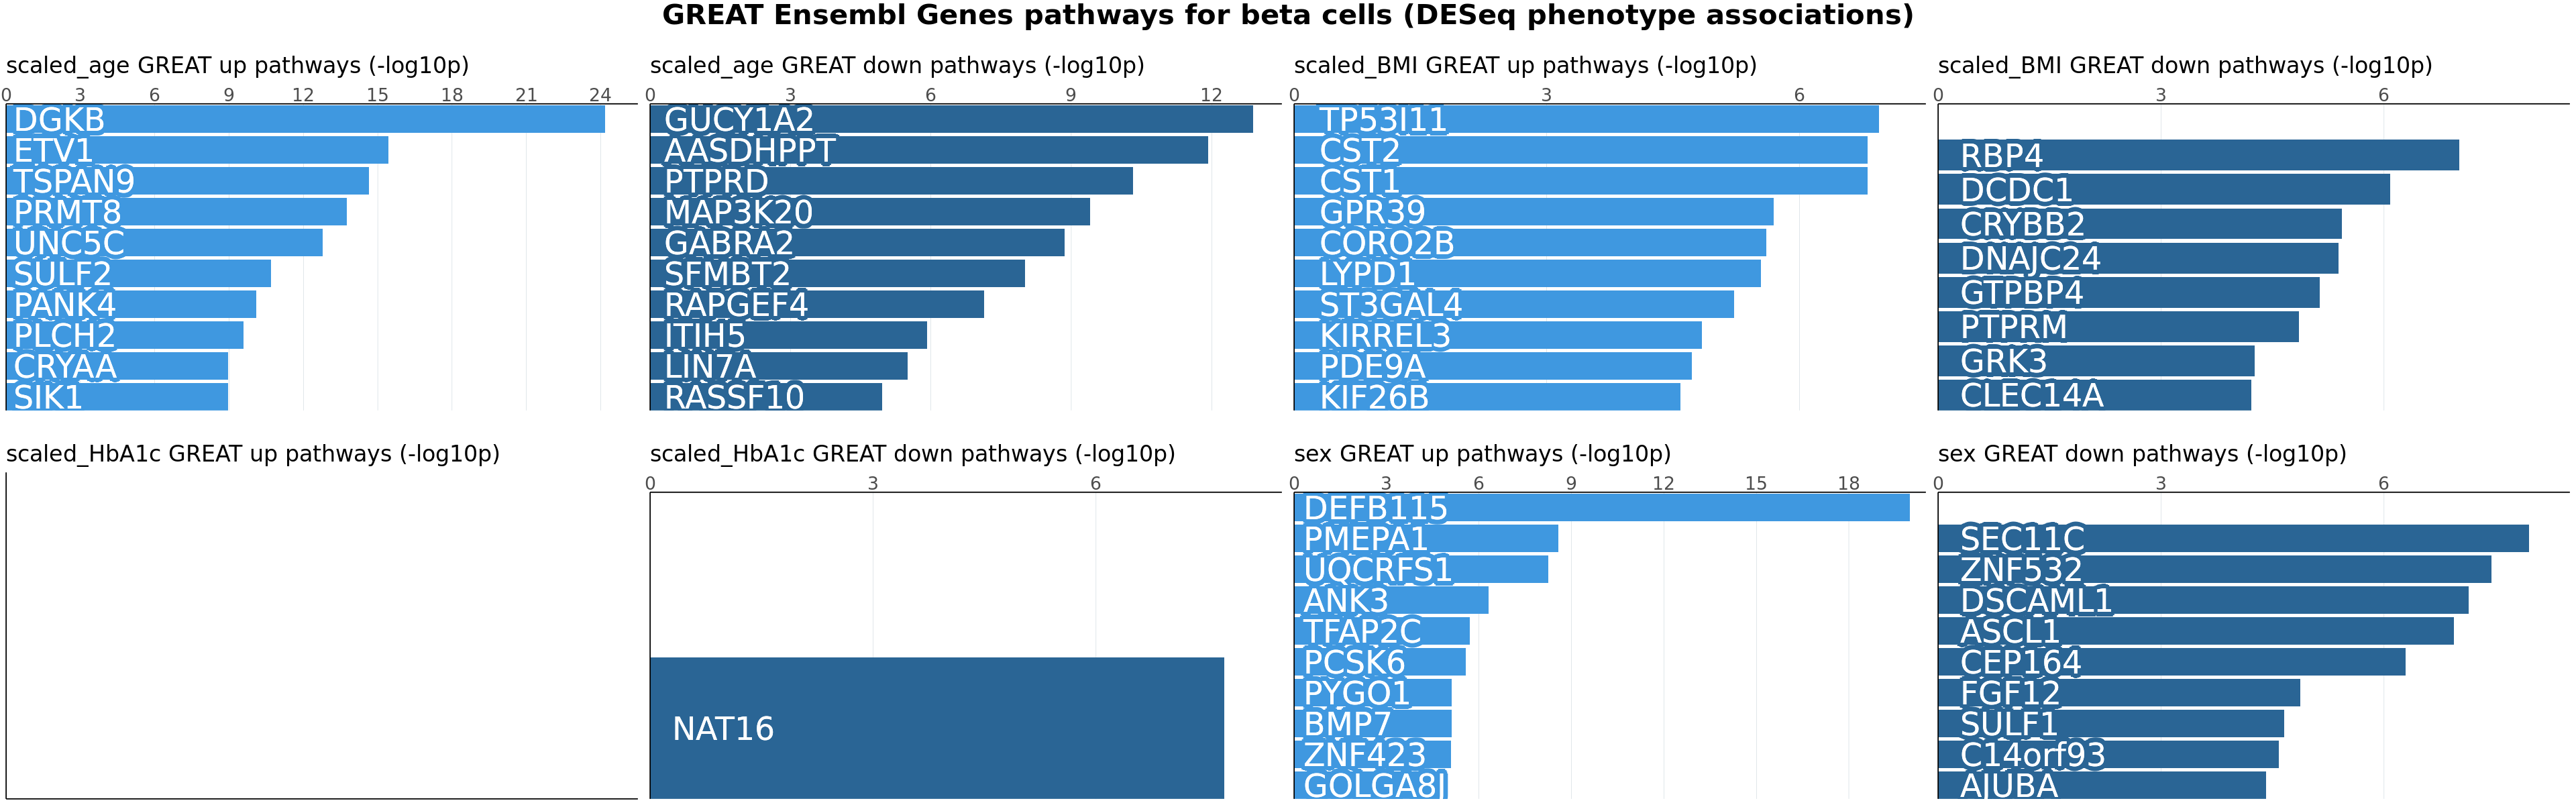

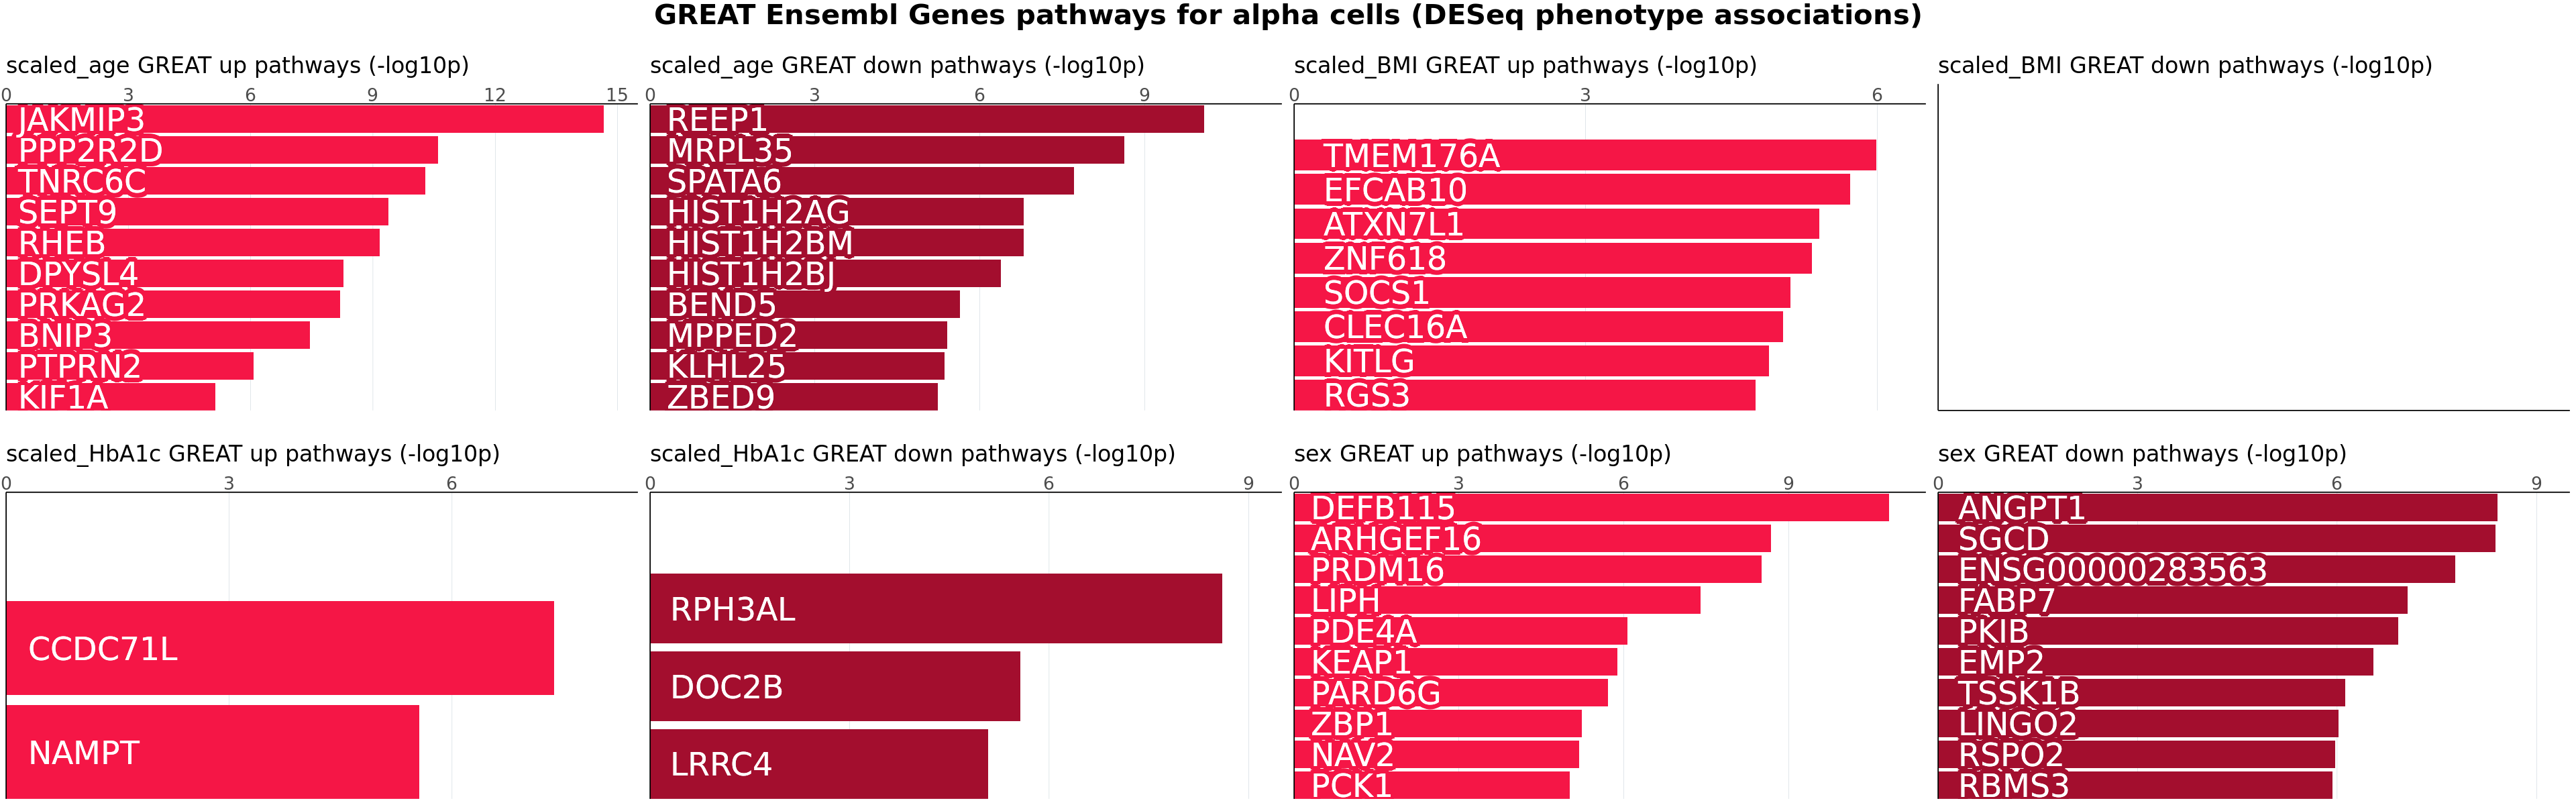

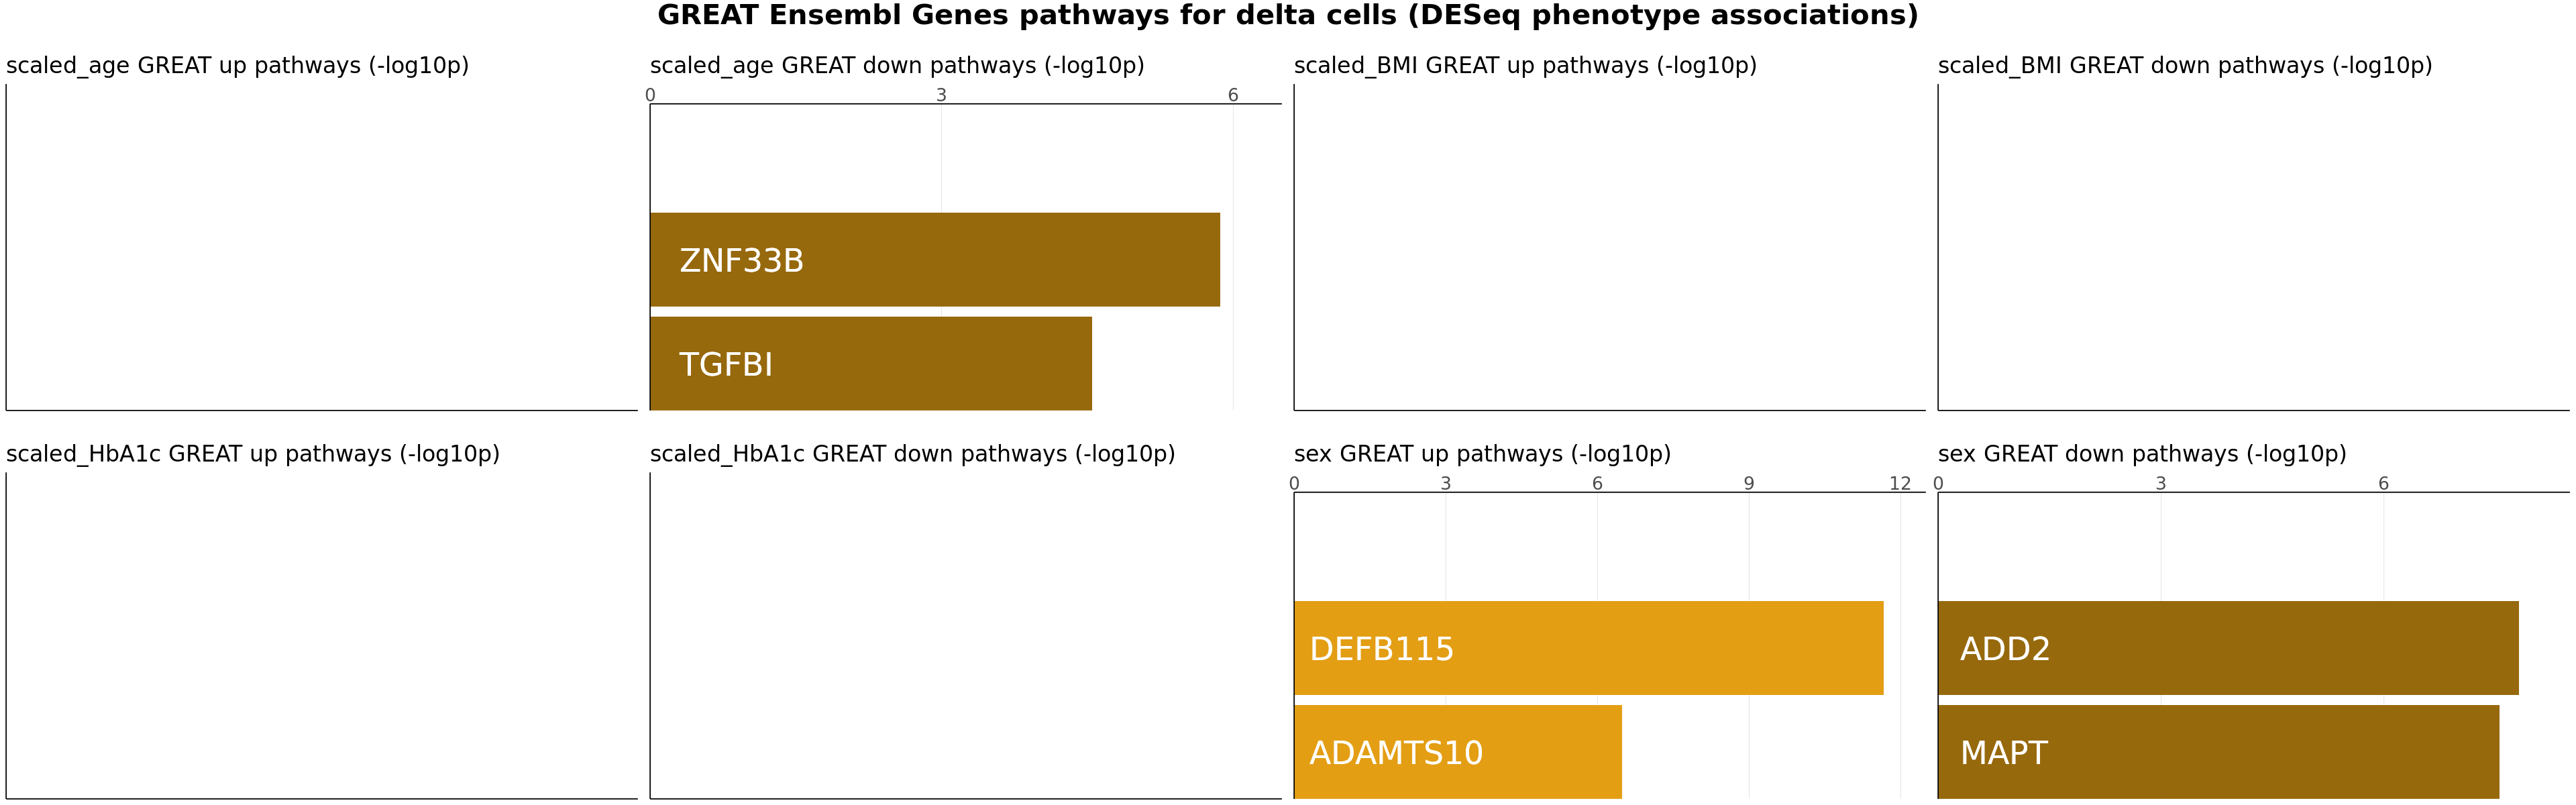

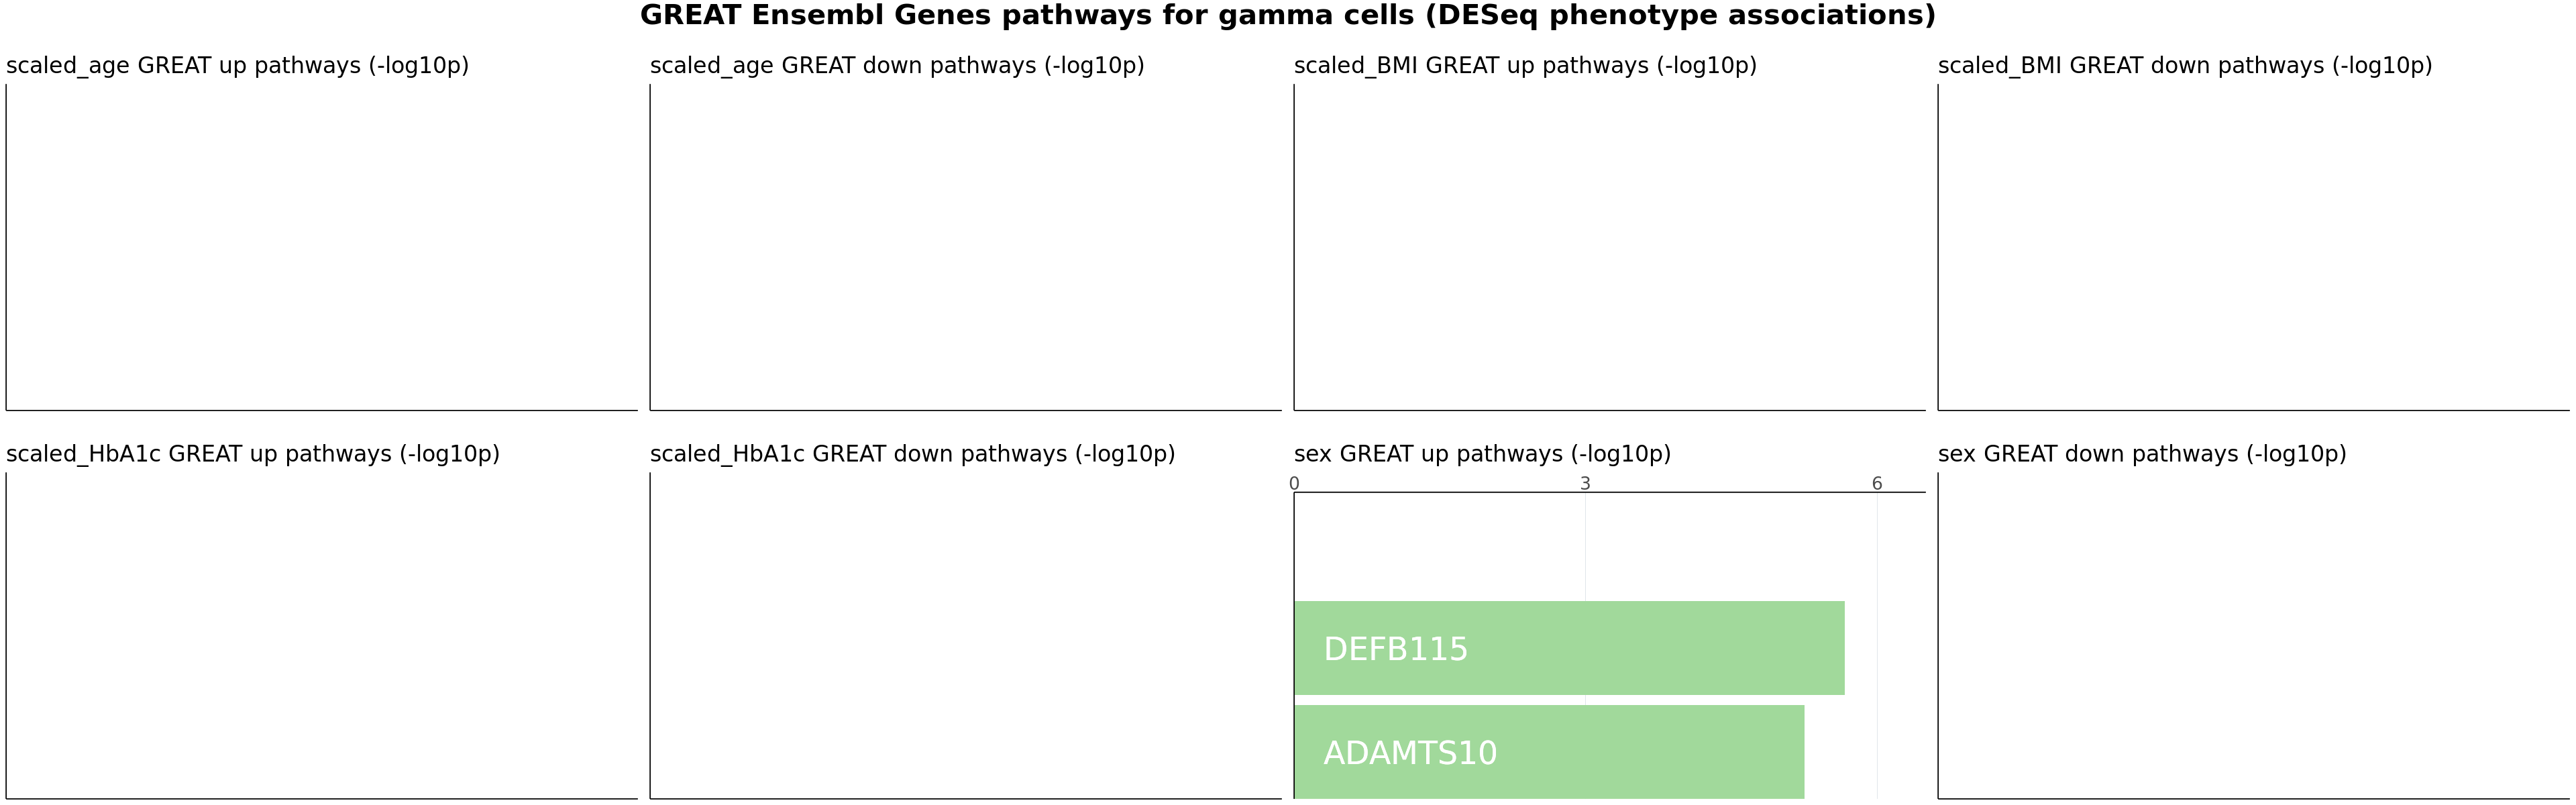

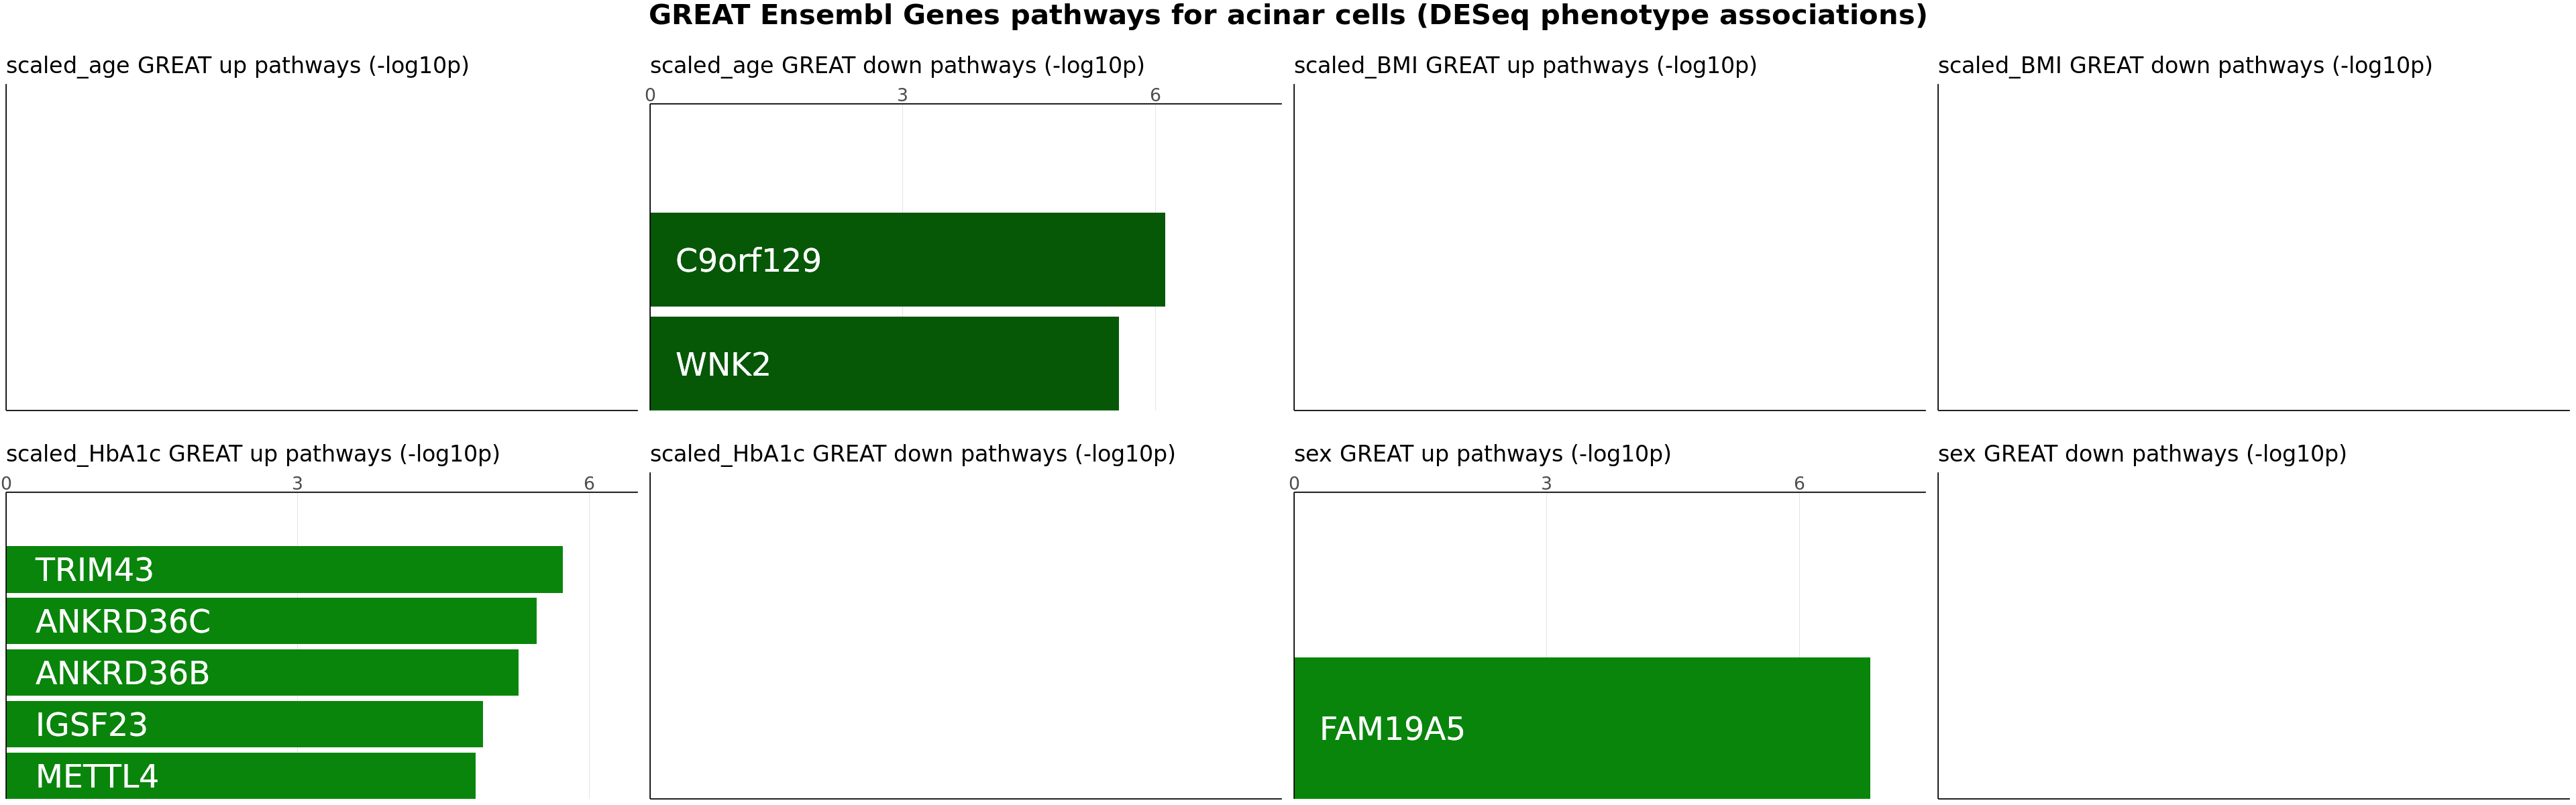

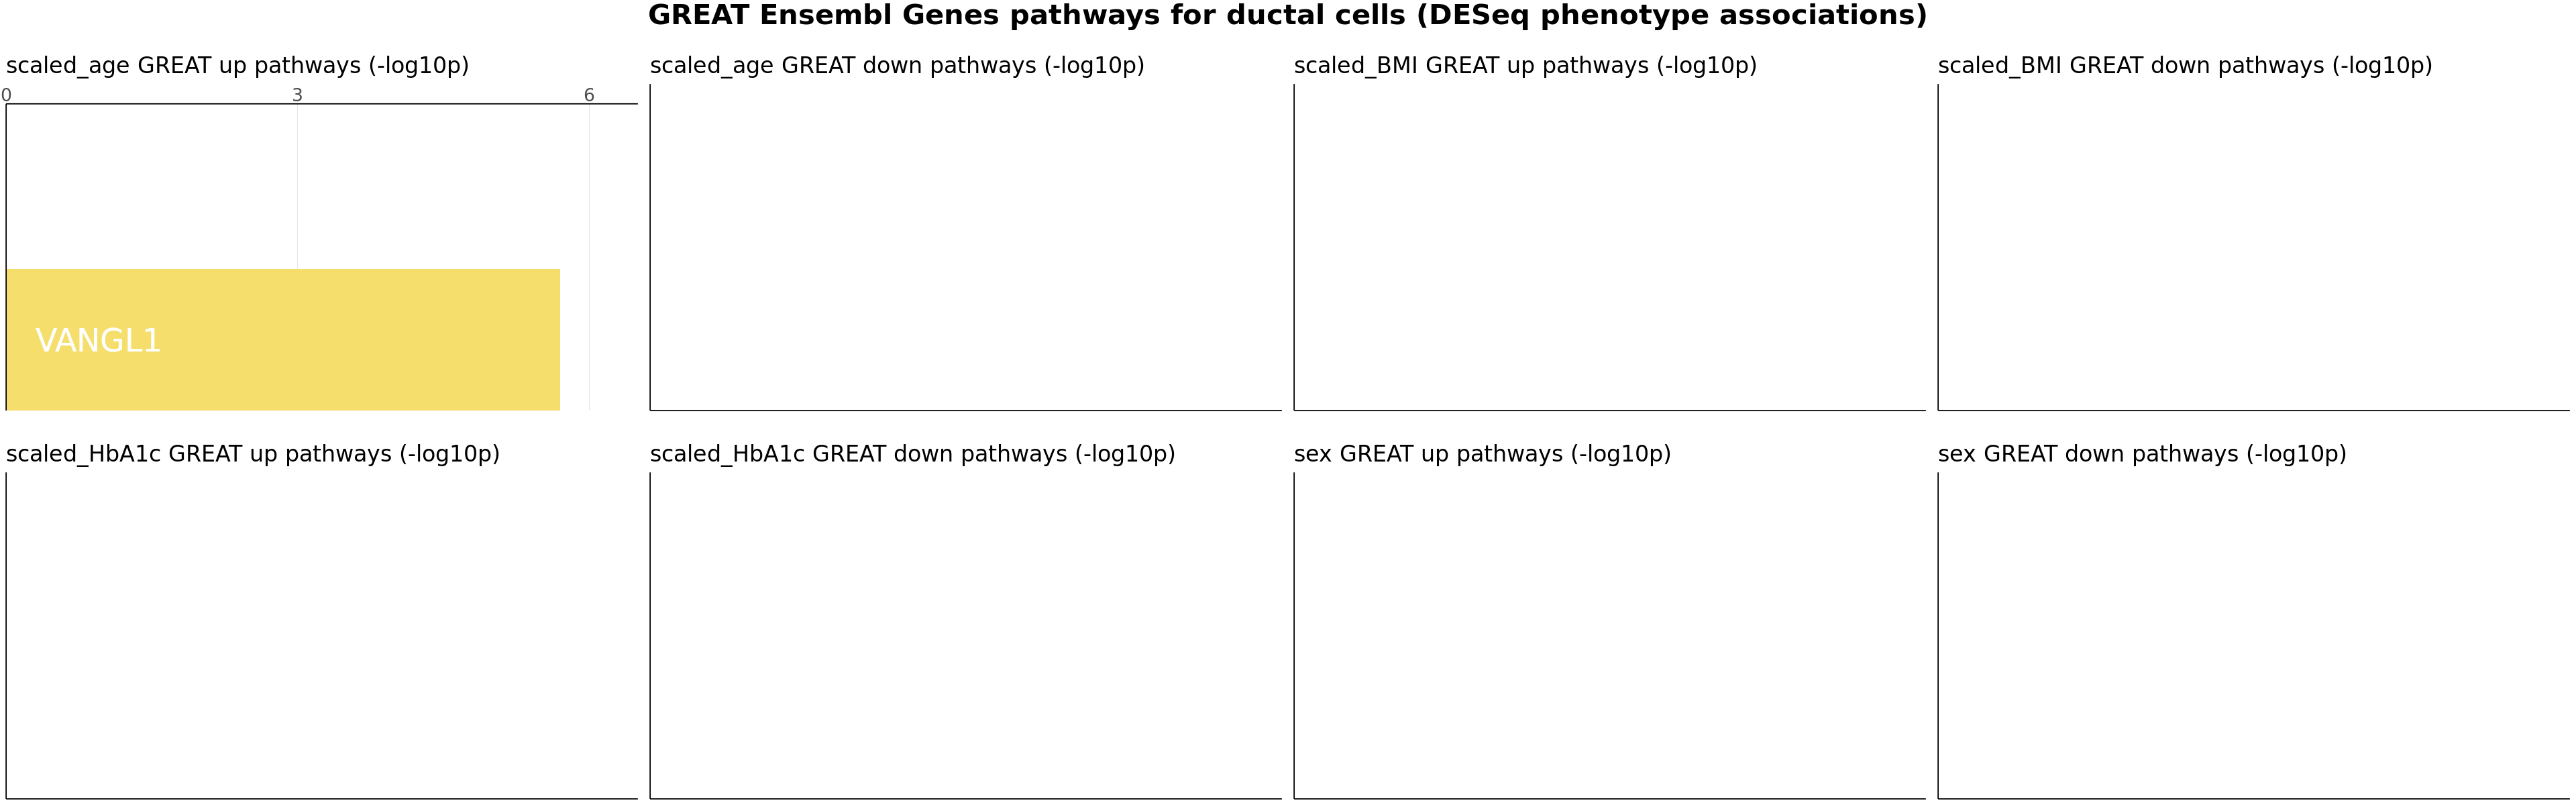

In [23]:
for (celltype in joint_celltypes){
    suppressWarnings(make_ct_great_plots(celltype, traits, 'Ensembl Genes', colors, 0.1))
}

# 2. Motif enrichment with HOMER

In [8]:
### Function to run HOMER on all sets of sig results
run_HOMER <- function(celltype, trait, dir, outdir, homer_dir, script_fp){
    #check if there are enough sig results for the association in the great_dir
    bed_fp <- file.path(outdir, 'ATAC', 'sig_assoc_peaks', trait, sprintf('%s_%s_sig_peaks_%s.bed', celltype, trait, dir))
    
    if(file.exists(bed_fp)){
        #set up homer code
        bg_fp <- file.path(bg_dir, sprintf('%s_peaks.bed',celltype))
        out_dir <- file.path(homer_dir, trait, paste(celltype,dir,sep='_'))
        dir.create(out_dir, recursive=TRUE, showWarnings=FALSE)
        log_fp <- file.path(outdir, 'log_HOMER.txt')
        cmd <- sprintf('perl /path/to/homer/bin/findMotifsGenome.pl %s hg38 %s -bg %s -size 200 -p 20 -bits > %s', bed_fp, out_dir, bg_fp, log_fp)
        write(cmd, script_fp, append=TRUE)
    }
}

In [10]:
great_dir <- file.path(outdir,'ATAC/GREAT')

In [11]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
homer_dir <- file.path(outdir, 'ATAC', 'HOMER')
script_fp <- file.path(homer_dir,'HOMER_commands.sh')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            run_HOMER(celltype, trait, dir, great_dir, homer_dir, script_fp)
        }
    }
}

Run the script in the terminal (in parallel and in a screen). Example:
```
screen -S motifs
cd /nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER
parallel -j 7 < 240426_HOMER_commands.sh
```

## After HOMER is done running parse results and visualize

In [11]:
### Function to parse HOMER results into better format (based on code from Emily)
parse_HOMER_knownResults <- function(celltype, trait, dir, homer_dir){
    homer_fp <- file.path(homer_dir, trait, paste(celltype,dir,sep='_'), 'knownResults.txt')
    if(file.exists(homer_fp)){
        df <- fread(homer_fp)
    
        #select columns of interest and modify names
        df_fin <- copy(df)
        colnames(df_fin) <- c('motif','consensus','pval','log_pval','qval','target_seq_w_motif','perc_target_seq_w_motif','bg_seq_w_motif','perc_bg_seq_w_motif')    
        df_fin$perc_target_seq_w_motif <- gsub("[%]", "", df_fin$perc_target_seq_w_motif) #remove percents
        df_fin$perc_bg_seq_w_motif <- gsub("[%]", "", df_fin$perc_bg_seq_w_motif)
        df_fin <- df_fin %>% select(-c(consensus,target_seq_w_motif,bg_seq_w_motif)) %>%
                    mutate(motif_short=gsub("/.*",'',motif)) %>% mutate(motif_short=gsub("[(].*", "", motif_short)) %>% #shorten motif names to TFs
                    mutate_at(c('perc_target_seq_w_motif','perc_bg_seq_w_motif'),as.numeric) %>% #convert percents to numeric
                    mutate(fc=(perc_target_seq_w_motif-perc_bg_seq_w_motif)/perc_bg_seq_w_motif) %>% #calculate foldchange
                    mutate(l2fc=log2(abs(fc))) #take log2 of foldchange
        #recalc the qvalue with out preferred method
        df_fin$neglog10p <- -log10(df_fin$pval)
        df_fin$padj <- p.adjust(p=df_fin$pval, method='BH', n=nrow(df_fin))

        #write to file non-sig motifs
        out_fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_ALL_motifs.bed', celltype, trait, dir))
        write.table(df_fin, out_fp, sep='\t', row.names=FALSE, quote=FALSE)               
        
        #cut to sig motifs and do final reordering
        df_sig <- subset(df_fin, padj < 0.1)
        df_sig <- df_sig %>% select(-c(log_pval,qval)) %>% relocate(c(neglog10p,padj), .after=pval)
        print(paste(homer_fp, dim(df_sig)[1]))

        #write to file
        if(dim(df_sig)[1] > 0){
            out_fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, dir))
            write.table(df_sig, out_fp, sep='\t', row.names=FALSE, quote=FALSE)               
        }
    }
}

In [13]:
traits <- c('scaled_age', 'scaled_BMI', 'scaled_HbA1c', 'sex')
homer_dir <- file.path(outdir, 'ATAC', 'HOMER')

for(celltype in joint_celltypes){
    for(trait in traits){
        for(dir in c('up','down')){
            parse_HOMER_knownResults(celltype, trait, dir, homer_dir)
        }
    }
}

[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_age/beta_up/knownResults.txt 20"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_age/beta_down/knownResults.txt 2"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_BMI/beta_up/knownResults.txt 3"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_BMI/beta_down/knownResults.txt 0"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/scaled_HbA1c/beta_down/knownResults.txt 0"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/HOMER/sex/beta_up/knownResults.txt 0"
[1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_asso

## Basic summary plots

In [41]:
### summarize sig genes results (plot with up and down as + and -)
summarize_HOMER_sig_motifs <- function(traits, celltypes, deseq_outdir, colors, padj_cutoff=0.1){
    #collect up and down info separately
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, 'up'))
            if(file.exists(fp)){
                df <- read.table(fp, sep='\t', header=TRUE)
                num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$fc > 0,])[1])                
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    colnames(summary_df_up) <- traits

    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(homer_dir,'sig_motifs',sprintf('%s_%s_%s.HOMER_sig_motifs.bed', celltype, trait, 'down'))
            if(file.exists(fp)){
                df <- read.table(fp, sep='\t', header=TRUE)
                num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$fc > 0,])[1])                
            } else {
                num_sig <- c(num_sig, 0)
            }
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    colnames(summary_df_down) <- traits

    #merge up/down dfs into one dataframe
    summary_df_up$celltype <- celltypes
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'), melt(summary_df_down, id.vars='celltype'))

    # Make grouped barplot of desired metadata
    options(repr.plot.width=16, repr.plot.height=8)
    theme_set(
        theme_classic())

    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Celltype", y='Num sig motifs', color="Cell Type") + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

Warning message in melt(summary_df_up, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_up). In the next version, this warning will become an error.”
Warning message in melt(summary_df_down, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_down). In the next version, this warning will become an error.”


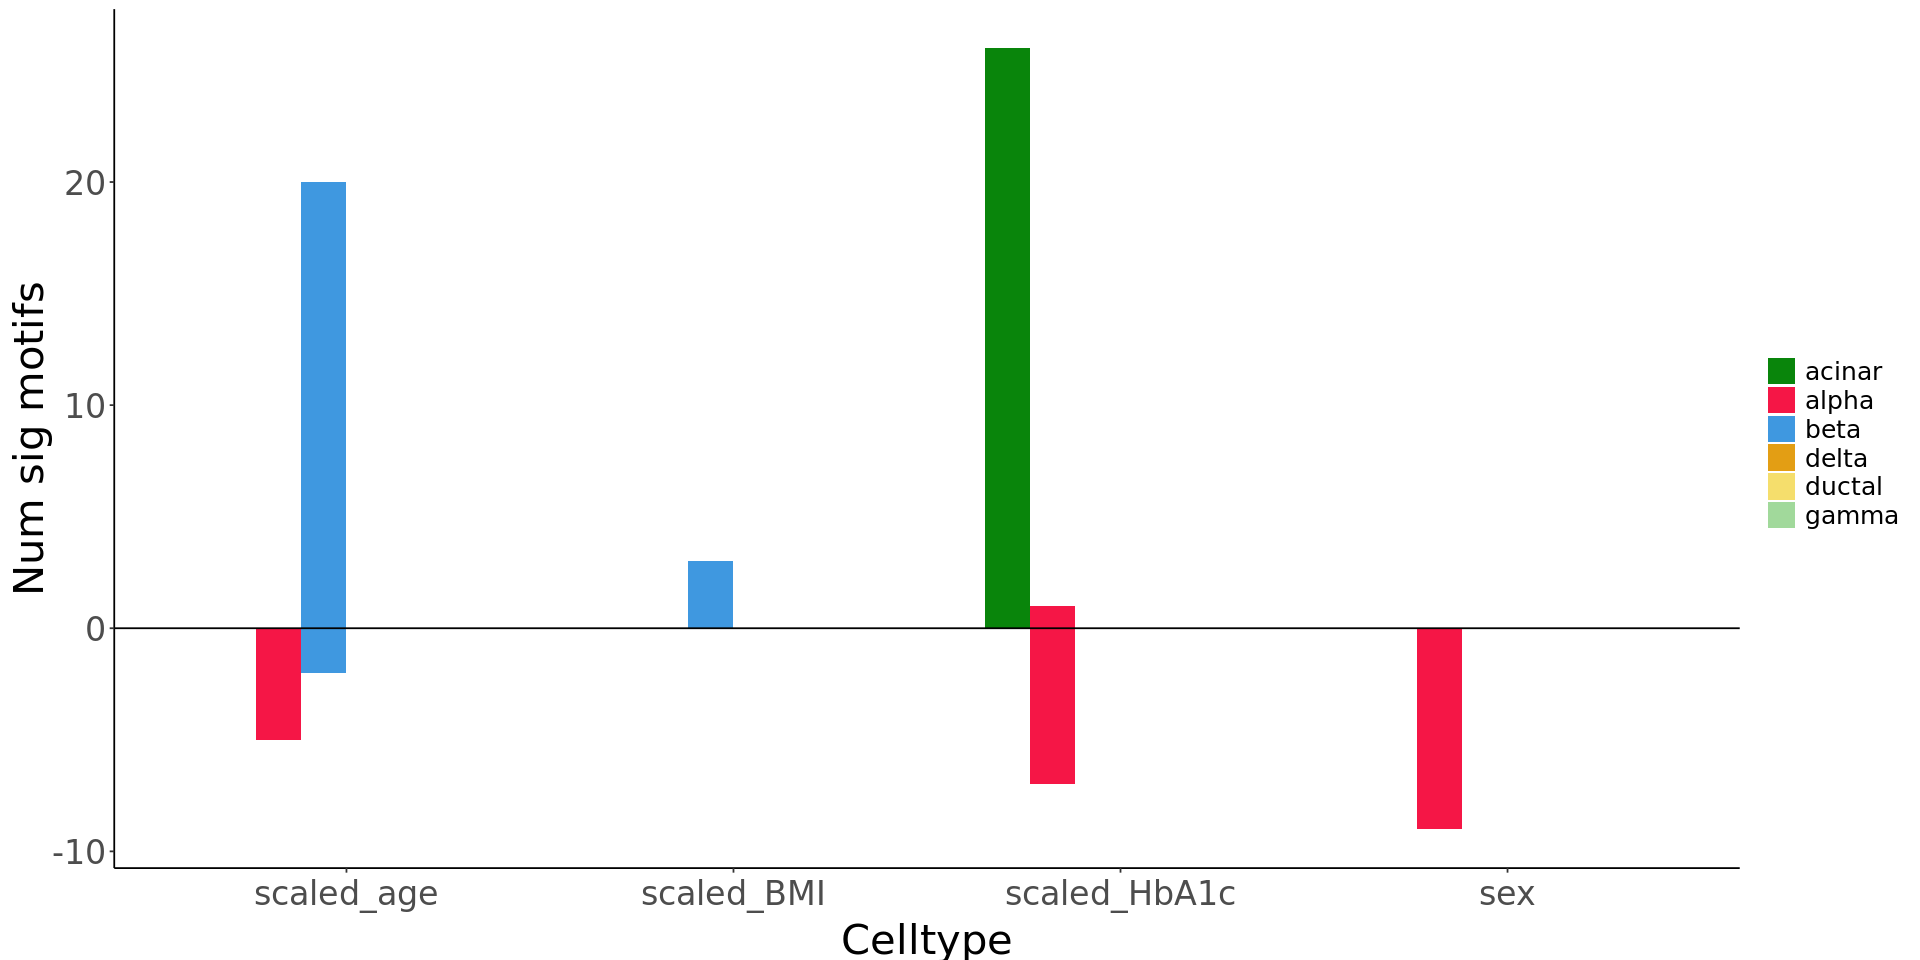

In [42]:
summarize_HOMER_sig_motifs(traits, joint_celltypes, homer_dir, colors)

# 3. Check if linked genes have concordant phenotype changes

## Make pathways out of linked genes and run fGSEA on the trait association results

In [9]:
fgsea_outdir <- file.path(outdir,'ATAC','linked_gene_fGSEA')
gmt_dir <- file.path(fgsea_outdir,'gmt_files')

In [11]:
### Function to extract all cREs nominally linked to a trait in a celltype (and in certain direction!)
get_nominal_cres <- function(celltype, trait, dir, p_cutoff=0.01){
    fp <- file.path(deseq_outdir,trait,sprintf('ATAC_deseq_v4.%s.%s.tsv',trait, celltype))
    df <- read.table(fp, sep='\t', header=1)
    if (dir=='up') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange > 0)
    if (dir=='down') df_sig_dir <- subset(df, pvalue<p_cutoff & log2FoldChange < 0)    
    sig_peaks <- row.names(df_sig_dir)
    sig_df <- as.data.frame(str_split_fixed(sig_peaks,'-',3))
    sig_df$V4 <- sig_peaks
    return(sig_df)
}

In [12]:
### Function to get the list of all genes linked to 1/+ peaks in a list
### Note: peaks are union peaks, so use those links files (also format: chr-start-end)
get_linked_genes <- function(celltype, cres, method_strs){
    fp <- file.path(links_dir, sprintf('%s_all_methods_links.wHeader.bedpe',celltype))
    df <- read.table(fp, sep='\t', header=1)
    df$cre <- paste(df$chr, df$start, df$end, sep='-')
    genes <- subset(df, cre %in% cres & method_str %in% method_strs) %>% pull(gene)
    return(genes)
}

In [16]:
dfs <- list()

for(celltype in joint_celltypes){
    for(trait in traits){
        up_cres <- get_nominal_cres(celltype, trait, 'up')
        down_cres <- get_nominal_cres(celltype, trait, 'down')
        up_genes <- get_linked_genes(celltype, sort(unique(up_cres$V4)), link_methods)
        down_genes <- get_linked_genes(celltype, sort(unique(down_cres$V4)), link_methods)

        df1 <- data.frame(id=paste(celltype,trait,'up',sep='-'), name=paste(celltype,trait,'up',sep='-'), gene=up_genes)
        df2 <- data.frame(id=paste(celltype,trait,'down',sep='-'), name=paste(celltype,trait,'down',sep='-'), gene=down_genes)
        gmt_df <- rbind(df1,df2)
        dfs[[paste(celltype,trait,sep='-')]] <- gmt_df
    }
}

In [18]:
fin_gmt <- as.data.frame(rbindlist(dfs))
dim(fin_gmt)
head(fin_gmt)

[1] 68338     3

,id,name,gene
,<chr>,<chr>,<chr>
1,beta-scaled_age-up,beta-scaled_age-up,ATAD3A
2,beta-scaled_age-up,beta-scaled_age-up,PLCH2
3,beta-scaled_age-up,beta-scaled_age-up,PANK4
4,beta-scaled_age-up,beta-scaled_age-up,PLCH2
5,beta-scaled_age-up,beta-scaled_age-up,SKI
6,beta-scaled_age-up,beta-scaled_age-up,PRDM16


In [26]:
out_fp <- file.path(gmt_dir, 'all_cts_trait_assoc_nom_peak_linked_genes.gmt')
writeGMT(fin_gmt, out_fp)

## Run fGSEA using linked genes pathways

In [27]:
### Function to run fGSEA and write outputs to a file
run_fGSEA_on_REM <- function(celltype, trait, pathways, pathways_name, outdir, only_auto=FALSE){
    #read in REM results and calculate rank?
    fp <- file.path(rna_deseq_outdir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
    df <- read.table(fp, sep='\t', header=1)
    
    # If only_auto==TRUE, remove any genes on sex chromosomes
    if(only_auto==TRUE){
        ref_df <- read.table('non-diabetic-islet-multiomics/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE)
        auto_genes <- subset(ref_df, !grepl('X|Y',V1)) %>% pull(V4)
        df_fin <- df[row.names(df) %in% auto_genes,]
    } else{
        df_fin <- df
    }
    rank <- -log10(df_fin$pvalue) * df_fin$effect
    names(rank) <- rownames(df_fin)

    #Run fGSEA
    res <- fgsea(pathways = pathways, 
                 stats    = rank,
                 eps      = 0.0,
                 minSize  = 0,
                 maxSize  = Inf)

    # Output results to a file (sorted by padj)
    out_fp <- file.path(outdir, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
    fwrite(res[order(res$padj),], file=out_fp, sep="\t", sep2=c("", " ", ""))
}

In [28]:
rna_celltypes <- c('beta','alpha','delta','acinar','ductal','immune','stellate')

In [29]:
rna_deseq_outdir <- file.path(outdir,'RNA','REM_meta')

In [35]:
pathway_fp <- file.path(gmt_dir, 'all_cts_trait_assoc_nom_peak_linked_genes.gmt')
pathways <- gmtPathways(pathway_fp)
name <- 'all_cts'

#run fgsea with pathways
for(trait in traits){
    trait_outdir <- file.path(fgsea_outdir, trait)
    dir.create(trait_outdir, showWarnings=FALSE)
    
    for(celltype in rna_celltypes){
        run_fGSEA_on_REM(celltype, trait, pathways, name, trait_outdir, FALSE)
    }
}

Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


## Summarize all results as heatmaps

In [42]:
### Function so I can run this easily on all 3 different linked genes sets
plot_comp_heatmap <- function(results, pathways_name, assoc_order, pathway_order){
    rna_pal <- c('#D73027','#E6938E','#F5F5F5','#94B5E1','#3375CC')
    options(repr.plot.width=24, repr.plot.height=12)
    theme_set(
        theme_classic())
    
    p1 <- ggplot(results, aes(x=pathway, y=deseq_res, fill=rank, label=sig)) +
            geom_tile(color='white') + 
            scale_fill_gradient2(low = rna_pal[5], mid = rna_pal[3], high = rna_pal[1]) + 
            geom_text(aes(label=sig, x=pathway, y=deseq_res), color='black', vjust=0.65, size=8) + 
            ylab('DESeq results') + xlab('Linked genes pathway') + ggtitle(sprintf('fGSEA of %s linked genes in RNA REM results',pathways_name)) +
            theme(axis.title=element_text(size=20),
                  axis.text.x=element_text(size=15,angle=30, hjust=1),
                  axis.text.y=element_text(size=15),
                  axis.ticks.length=unit(0.25,'cm'),
                  legend.title=element_text(size=15),
                  legend.text=element_text(size=15),
                  legend.key.size=unit(0.75,'cm'),
                  panel.border=element_rect(color='black',fill=NA, size=1))
    p1$data$deseq_res = factor(x=p1$data$deseq_res,levels=rev(assoc_order))
    p1$data$pathway = factor(x=p1$data$pathway,levels=pathway_order)
    p1$data$celltype = factor(x=p1$data$celltype,levels=rna_celltypes)
    p1$data$celltype2 = factor(x=p1$data$celltype2,levels=rna_celltypes)
    p1 + facet_grid(celltype ~ celltype2, scales='free')
}

In [43]:
### Wrapper for heatmap function
comp_heatmap_wrapper <- function(celltypes, traits, pathways_name, padj_cutoff=0.1, pval_cutoff=0.05){
    results <- data.frame()
    for(trait in traits){
        for(celltype in celltypes){
            fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
            df <- as.data.frame(fread(fp))
            df <- df %>% select(-leadingEdge)
            df$deseq_res <- paste(celltype,trait,sep='-')
            df$celltype <- celltype
            results <- rbind(results, df)
        }
    }
    results$pval[results$pval<1e-10] <- 1e-10
    results$sign_logp <- -log10(results$pval) * sign(results$NES)
    results$rank <- -log10(results$pval) * results$NES
    results$sig <- ifelse(results$padj < 0.1, '*',ifelse(results$pval<0.05,'\u00b0',''))
    results$celltype2 <- str_split_fixed(results$pathway,'-',3)[,1]

    #inputs for heatmap
    gmt_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/linked_gene_fGSEA/gmt_files'
    pathway_order <- fread(file.path(gmt_dir,'all_cts_trait_assoc_nom_peak_linked_genes.gmt'), fill=TRUE)$V1
    assoc_order <- paste(rep(rna_celltypes,each=4),traits,sep='-')
    
    #make heatmap!
    print(plot_comp_heatmap(results, pathways_name, assoc_order, pathway_order))
}

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 2 rows containing missing values (`geom_text()`).”


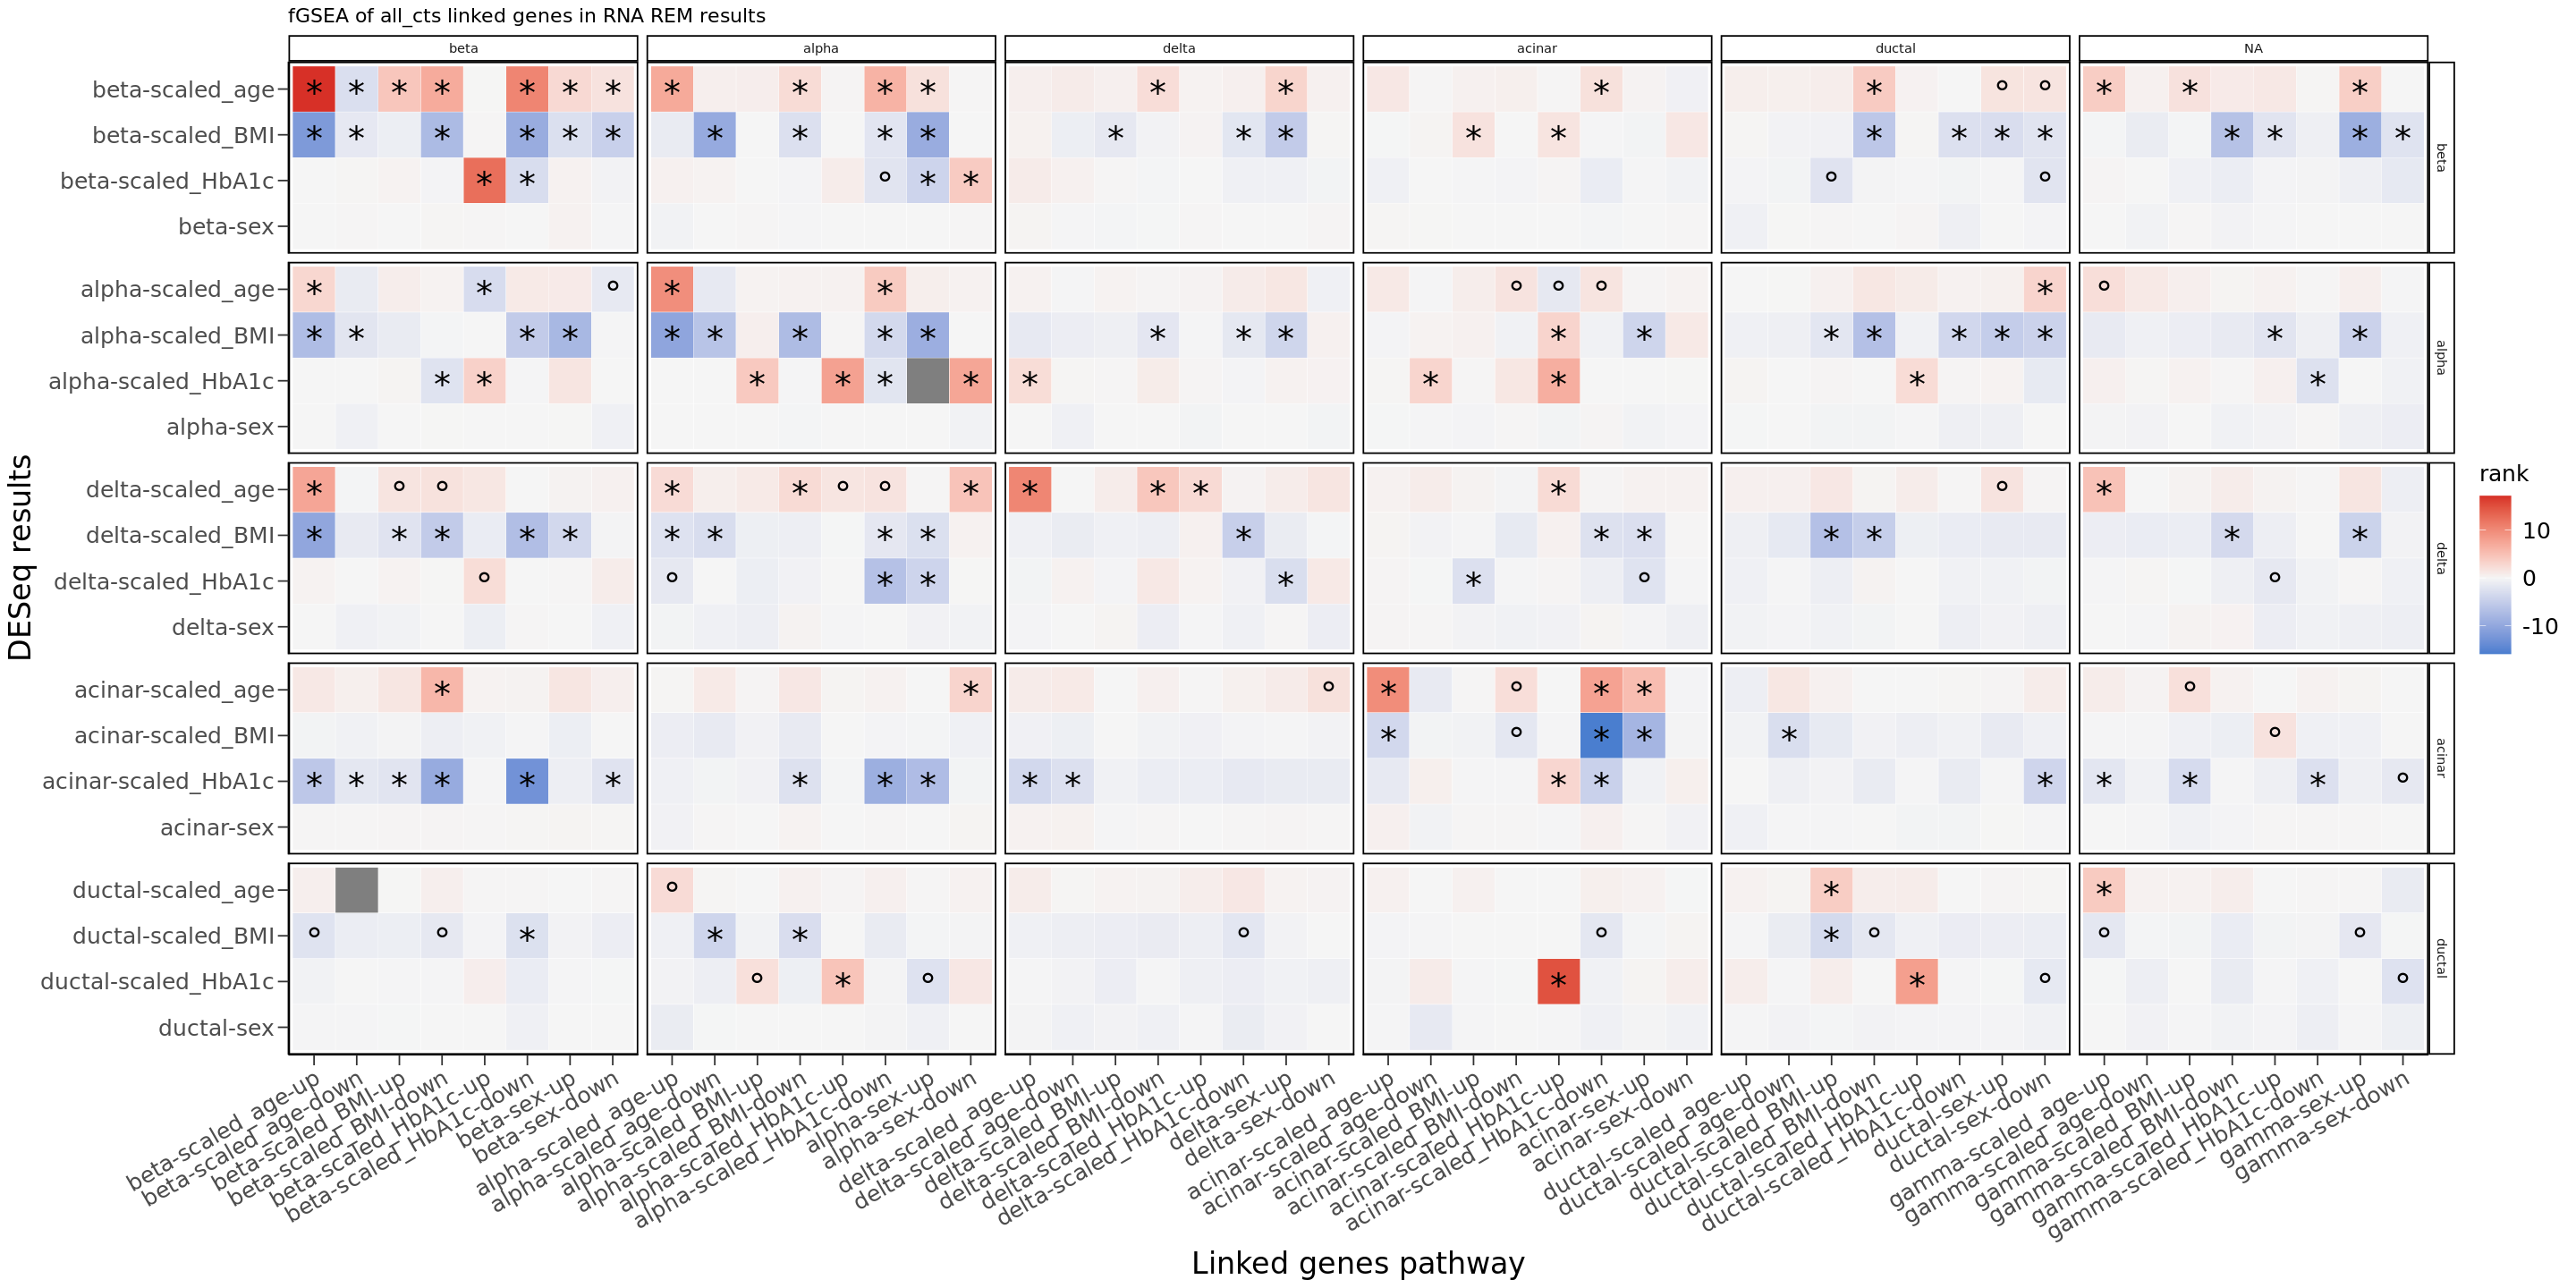

In [44]:
comp_heatmap_wrapper(rna_celltypes[seq(5)], traits, 'all_cts')

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] fgsea_1.20.0         rWikiPathways_1.14.0 enrichR_3.1         
 [4] forcats_0.5.2        shadowtext_0.1.2     RColorBrewer_1.1-3  
 [7] ggrepel_0.9.4        ggpubr_0.5.0         ggplot2_3.4.4       
[10] readr_2.1.1          stringi_1.8.2        str